In [2]:
import pandas as pd
import numpy as np
import random
import requests

# Don't forget to 'pip install fastf1'
import fastf1 as ff1

# Don't forget to 'pip install seaborn'
import seaborn as sns
import matplotlib.pyplot as plt
ff1.Cache.enable_cache('cache')

In [3]:
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()
    
    return response['MRData']

In [37]:

season = 2021
rounds_url = ergast_retrieve(f'{season}')
rounds=rounds_url['total']
rounds=int(rounds)

In [38]:
# Specify the number of rounds we want in our plot (in other words, specify the current round)

# Initiate an empty dataframe to store our data
all_championship_standings = pd.DataFrame()

# We also want to store which driver drives for which team, which will help us later
driver_team_mapping = {}

# Initate a loop through all the rounds
for i in range(1, rounds+1):
    # Make request to driverStandings endpoint for the current round
    race = ergast_retrieve(f'{season}/{i}/driverStandings')
    
    # Get the standings from the result
    standings = race['StandingsTable']['StandingsLists'][0]['DriverStandings']

    # Initiate a dictionary to store the current rounds' standings in
    current_round = {'round': i}
    
    # Loop through all the drivers to collect their information
    for i in range(len(standings)):
        driver = standings[i]['Driver']['code']
        position = standings[i]['position']
        
        # Store the drivers' position
        current_round[driver] = int(position)
        
        # Create mapping for driver-team to be used for the coloring of the lines
        driver_team_mapping[driver] = standings[i]['Constructors'][0]['name']


    # Append the current round to our fial dataframe
    all_championship_standings = all_championship_standings._append(current_round, ignore_index=True)
    
# Set the round as the index of the dataframe
all_championship_standings = all_championship_standings.set_index('round')

#standings

In [39]:
# Melt data so it can be used as input for plot
all_championship_standings_melted = pd.melt(all_championship_standings.reset_index(), ['round'])

In [25]:
from fastf1 import plotting

In [44]:
all_championship_standings.columns

Index(['HAM', 'VER', 'BOT', 'NOR', 'PER', 'LEC', 'RIC', 'SAI', 'TSU', 'STR',
       'RAI', 'GIO', 'OCO', 'RUS', 'VET', 'MSC', 'GAS', 'LAT', 'ALO', 'MAZ',
       'KUB'],
      dtype='object')

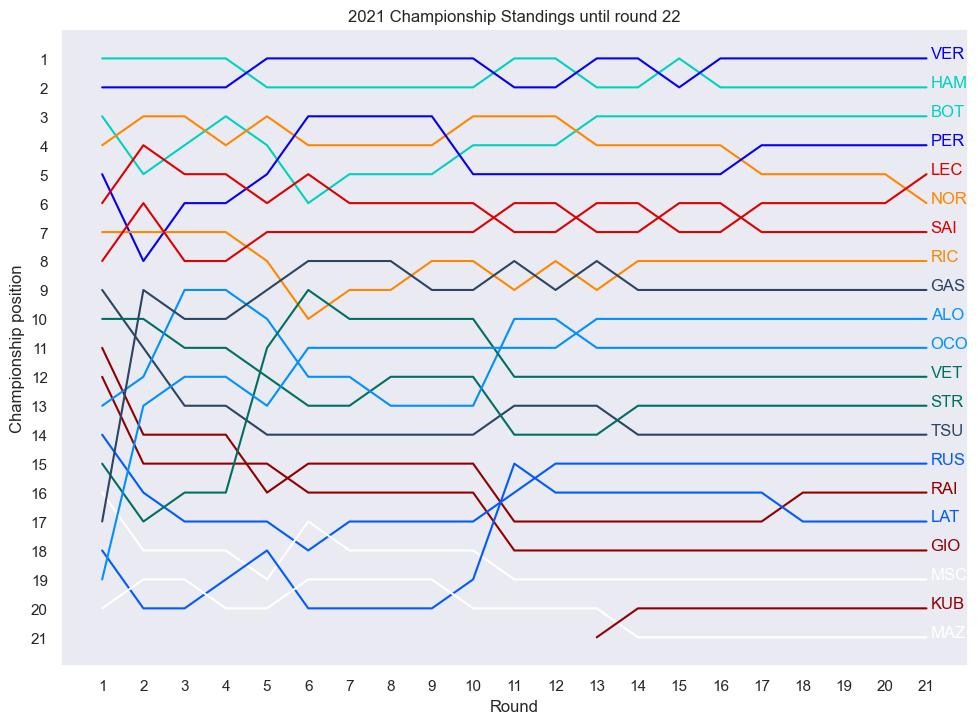

In [41]:
# Increase the size of the plot 
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Initiate the plot
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title(f'{season} Championship Standings until round {rounds}')

# Draw a line for every driver in the data by looping through all the standings
# The reason we do it this way is so that we can specify the team color per driver
for driver in pd.unique(all_championship_standings_melted['variable']):
    sns.lineplot(
        x='round', 
        y='value', 
        data=all_championship_standings_melted.loc[all_championship_standings_melted['variable']==driver], 
        color=ff1.plotting.team_color(driver_team_mapping[driver])
    )

# Invert Y-axis to have championship leader (#1) on top
ax.invert_yaxis()

# Set the values that appear on the x- and y-axes
ax.set_xticks(range(1, rounds))
ax.set_yticks(range(1, 22))

# Set the labels of the axes
ax.set_xlabel("Round")
ax.set_ylabel("Championship position")

# Disable the gridlines 
ax.grid(False)


# Add the driver name to the lines
for line, name in zip(ax.lines, all_championship_standings.columns.tolist()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]
        
    text = ax.annotate(
        name,
        xy=(x + 0.1, y),
        xytext=(0, 0),
        color=line.get_color(),
        xycoords=(
            ax.get_xaxis_transform(),
            ax.get_yaxis_transform()
        ),
        textcoords="offset points"
    )

# Save the plot
plt.savefig('img/championship_standings.png')